# Интро
В этом буке мы выполняем EDA для датасета об учениках, которые будут сдавать математику

**Цель - Научится работать в направлении EDA**

	Задачи:
		1) Загрузить данные
		2) Проработать пропуски
		3) Найти связи номенативной переменной и целевой
		4) Провести корреляционый анализ
		5) Поработать с выбросами
		6) Сделать one-hote-encoding
		7) Обучить модель
		8) Оценить модель

In [103]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.mlab as mlab
import seaborn as sns
from itertools import combinations
from scipy.stats import ttest_ind
import statistics
from numbers import Number
from decimal import Decimal


from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn import metrics  # подгружаем метрики

plt.style.use('ggplot')     # правильный (очень красивый) стиль у графиков

%matplotlib inline


pd.set_option('display.max_rows', 50)  # показывать больше строк
pd.set_option('display.max_columns', 50)  # показывать больше колонок

df_math = pd.read_csv('stud_math.csv.xls')  # Загрузить данные

# Этап №0
Смотрима на состав данных, оцениваем количество пропусков, виды переменных (числа или объекты)

In [2]:
df_math.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
0,GP,F,18,U,NaN,A,4.0,4.0,at_home,teacher,course,mother,2.0,2.0,0.0,yes,no,no,no,yes,-6.0,yes,NaN,no,4.0,3.0,4.0,3.0,6.0,30.0
1,GP,F,17,U,GT3,NaN,1.0,1.0,at_home,other,course,father,1.0,2.0,0.0,no,yes,no,no,no,-6.0,yes,yes,no,5.0,3.0,3.0,3.0,4.0,30.0
2,GP,F,15,U,LE3,T,1.0,1.0,at_home,other,other,mother,1.0,2.0,3.0,yes,no,NaN,no,yes,-6.0,yes,yes,NaN,4.0,3.0,2.0,3.0,10.0,50.0
3,GP,F,15,U,GT3,T,4.0,2.0,health,NaN,home,mother,1.0,3.0,0.0,no,yes,yes,yes,yes,-9.0,yes,yes,yes,3.0,2.0,2.0,5.0,2.0,75.0
4,GP,F,16,U,GT3,T,3.0,3.0,other,other,home,father,1.0,2.0,0.0,no,yes,yes,no,yes,-6.0,yes,no,no,4.0,3.0,2.0,5.0,4.0,50.0


In [3]:
df_math.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 30 columns):
school                 395 non-null object
sex                    395 non-null object
age                    395 non-null int64
address                378 non-null object
famsize                368 non-null object
Pstatus                350 non-null object
Medu                   392 non-null float64
Fedu                   371 non-null float64
Mjob                   376 non-null object
Fjob                   359 non-null object
reason                 378 non-null object
guardian               364 non-null object
traveltime             367 non-null float64
studytime              388 non-null float64
failures               373 non-null float64
schoolsup              386 non-null object
famsup                 356 non-null object
paid                   355 non-null object
activities             381 non-null object
nursery                379 non-null object
studytime, granular    388 non-

In [52]:
df_math.isnull().sum()

school         0
sex            0
age            0
address        0
famsize        0
Pstatus        0
Medu           0
Fedu           0
Mjob           0
Fjob           0
reason         0
guardian       0
traveltime     0
studytime      0
failures       0
schoolsup      0
famsup         0
paid           0
activities     0
nursery        0
higher         0
internet       0
romantic       0
famrel         0
freetime       0
goout          0
health         0
absences      18
score          0
Par_edu2       0
dtype: int64

In [53]:
df_math.shape

(395, 30)

Выборка состоит из 395 наблюдений, 30 признаков из которых 13 являются числовыми (целевая score), 8 бинарными (yes/no), 9 номенативными.
На 395 строк приходится 565 пропусков, с пропусками будем работать, что-бы не потерять данные

# Этап №1 
Пишем функции для обработки столбцов разных категрий.
Обработка заключается в замене значенией NaN на какое-либо значение из списка: other, mode(), mean(), yes/no с сохранением пропорции

Так же есть функция поиска столбцов со значениями цифр.
Функция для t-test.
Функция построения гистрограм и боксплотов.


In [113]:
# Функция заменяет пустые значения на other, если в столбце было такое значение other
def other_replacer(df_math):
    other_col_consist = []  # пустой список
    for i in df_math.columns:  # тут в цикле ищем столбцы, в которых в value_counts() есть other
        if 'other' in df_math[i].value_counts():
            other_col_consist.append(i)  # запоминаем эти столбцы

    for col in other_col_consist:  # пробегаем по всем столбцам и заменяем пустоту на other
        df_math.fillna(value={col: 'other'}, inplace=True)


# Функция заменяет пустые значения столбцов с типами значений int float на медианное
def mean_value_replacer(df_math):
    int_col_consist = find_cols_int(df_math)

    for col in int_col_consist:  # пробегаем по всем столбцам и заменяем пустоту на медианное
        df_math.fillna(value={col: df_math[col].median()}, inplace=True)

# Функция ищет колонки с типом данных float и int


def find_cols_int(df_math):
    int_col_consist = []
    matches = ['float', 'int']

    for i in df_math.columns:
        a_string = str(type(df_math[i].value_counts().index.max()))
        if any(x in a_string for x in matches):
            int_col_consist.append(i)

    return int_col_consist

# Фукнция заменяет пустоты в столбцах с данными yes/no


def zero_one_replacer(df_math):
    yes_no_col_consist = []
    for i in df_math.columns:
        if df_math[i].value_counts().get('yes') is not None:

            yes_no_col_consist.append(i)
#         else:
#             print('no yes')
#             print (df_math[col].value_counts().get('yes'))
    for col in yes_no_col_consist:  # пробегаем по всем столбцам и заменяем пустоту на yes limit=number_for_replace
        yes = df_math[col].value_counts().get('yes')
        no = df_math[col].value_counts().get('no')
        whole_num = df_math[col].shape[0]
#         print ('col is {} yes is :{} no is {}'.format(col,yes,no))
#         print(whole_num)
#         number_for_replace = int(round((whole_num - yes - no)/2))
        number_for_replace = int(round((whole_num-yes-no)*yes/(yes+no)))
#         print (number_for_replace)
        if number_for_replace > 0:
            df_math.fillna(value={col: 'yes'},
                           inplace=True, limit=number_for_replace)
        df_math.fillna(value={col: 'no'}, inplace=True)

#         df_math[col] = df_math[col].map({'yes': 1, 'no': 0}) #превращаем yes в 1, no в 0

# Функция замены данных на mode() в столбцах с номенативными данными


def nomenative_replacer(df_math):
    cols = ['address', 'famsize', 'Pstatus']
    for col in cols:
        #         size = df_math['address'].isnull().sum()
        df_math.fillna(value={col: df_math[col].mode()[0]}, inplace=True)

# Функция показывает кол-во признаков в столбце с номенативной переменной


def nomenative_freaqency_analytics(df_math):
    cols = ['address', 'famsize', 'Pstatus']
    for col in cols:
        display(pd.DataFrame(df_math[col].value_counts()))
        print("Значений, более 10 раз:",
              (df_math[col].value_counts() > 10).sum())
        df_math.loc[:, [col]].info()


# Функция построения столбиков для оценки влияния номенативных переменных на целевое значение
def bins_constructor_int(cols):
    #     df_math[cols].hist(label=cols})
    #     cacao.review_date.describe()

    x = df_math[cols]
    n_bins = len(x.unique())-1

#     fig, axes = plt.subplots(nrows=1, ncols=1)
#     ax0, ax1, ax2, ax3 = axes.flatten()

#     colors = cols
#     ax0.hist(x, n_bins, density=True, histtype='bar', color=colors, label=colors)
#     ax0.legend(prop={'size': 10})
#     ax0.set_title('bars about ')
#     fig.tight_layout()
#     plt.show()

    n, bins, patches = plt.hist(
        x, n_bins, facecolor='blue', alpha=0.5, histtype='bar')
    plt.xlabel(cols)
    plt.ylabel('count')
    plt.title('гистограмма для '+cols)
    plt.show()

# Функция построение боксплотов для номенативной переменной


def get_boxplot(column):
    fig, ax = plt.subplots(figsize=(14, 4))
    sns.boxplot(x=column, y='score',
                data=df_math.loc[df_math.loc[:, column].isin(
                    df_math.loc[:, column].value_counts().index[:10])],
                ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + column)
    plt.show()

# Оценка t-test, запоминаем столбцы, в которых есть статистически значимые различия для колонки


def get_stat_dif(column):
    cols = df_math.loc[:, column].value_counts().index[:10]
    combinations_all = list(combinations(cols, 2))
    get_stat_col = []
    for comb in combinations_all:
        if ttest_ind(df_math.loc[df_math.loc[:, column] == comb[0], 'score'],
                     df_math.loc[df_math.loc[:, column] == comb[1], 'score']).pvalue \
                <= 0.05/len(combinations_all):  # Учли поправку Бонферони
            #             print('Найдены статистически значимые различия для колонки', column)

            return column


# Функция вычитания list из list
def Diff(li1, li2):
    li_dif = [i for i in li1 + li2 if i not in li1 or i not in li2]
    return li_dif


# Функция убирает выбросы
def remove_vibrosi(cols):
    for col in cols:
        median = df_math[col].median()
        IQR = df_math[col].quantile(0.75) - df_math[col].quantile(0.25)
        perc25 = df_math[col].quantile(0.25)
        perc75 = df_math[col].quantile(0.75)
        print('25-й перцентиль: {},'.format(perc25), '75-й перцентиль: {},'.format(perc75), "IQR: {}, ".format(IQR),
              "Столб {} Границы выбросов: [{f}, {l}].".format(col, f=perc25 - 1.5*IQR, l=perc75 + 1.5*IQR))
        df_math[col].loc[df_math[col].between(
            perc25 - 1.5*IQR, perc75 + 1.5*IQR)].hist(label='IQR')
#         df_math[col].loc[df_math[col] <= 100].hist(alpha = 0.5,label = 'Здравый смысл')
        plt.legend()
        plt.show()

        # Фильтруем выбросы
        df_math[col] = df_math[col].loc[df_math[col].between(
            perc25 - 1.5*IQR, perc75 + 1.5*IQR)]
#         print(df_math.loc[df_math[col].between(perc25 - 1.5*IQR, perc75 + 1.5*IQR)])
#         cacao = cacao.loc[cacao.cocoa_percent <= 100]


# Функция строит график barplot по группировке по параметру(признаку) и показывает целевой показатель score
def look_at_categ_param(column, funct='mean'):
    if funct == 'median':
        group_by_param = df_math.groupby(column).median()
    elif funct == 'mean':
        group_by_param = round(df_math.groupby(column).mean(), 2)
    display(group_by_param)

    fig, ax = plt.subplots()
#     for a in [x, y]:
#         sns.distplot(a, bins=range(1, 110, 10), ax=ax, kde=False)
#     ax.set_xlim([0, 100])

    # df_2 = df.groupby('A').sum()
    group_by_param.reset_index(inplace=True)
    sns.barplot(x=column, y='score', hue='score', data=group_by_param)
    ax.set_title('Barplot for ' + column + ' funct '+funct)
    plt.show()


# Функция вывода метрик
def print_metrics(y_test, y_pred):
    print('MAE:', "%.4f" % metrics.mean_absolute_error(y_test, y_pred))
    print('RMSE:', "%.4f" % np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

# Этап №2
Обрабатываем пропуски и анализируем по графикам

In [56]:
other_replacer(df_math)  # Заменяем NaN на Other
mean_value_replacer(df_math)  # Заменяем NaN на median
# Заменяем NaN на yes ли no с сохраненеим пропопрций
zero_one_replacer(df_math)
# Заменяем номенативные переменные с использованеим mode()
nomenative_replacer(df_math)

# Проверяем число пропусков в датасете
if df_math.isnull().sum().sum() == 0:
    print('Пропусков нет')
     

Пропусков нет


Пропуски обработали, все ок, приступаем к анализу.

# Этап №2.1
Добавим новый признак

In [57]:
# Новый признак - максимум образования опекунов
df_math['Par_edu2'] = df_math.apply(lambda x: x.Medu if x.guardian == 'mother'
                                    else (x.Fedu if x.guardian == 'father' else x[['Medu', 'Fedu']].max()), axis=1)

# Новый признак оказался хламом

In [58]:
nomenative_freaqency_analytics(df_math) # пробегамеся по номенативным столбцам, не так уж много видов, похоже на бинарные данные

,address
U,312
R,83


Значений, более 10 раз: 2
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
address    395 non-null object
dtypes: object(1)
memory usage: 3.2+ KB


,famsize
GT3,288
LE3,107


Значений, более 10 раз: 2
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
famsize    395 non-null object
dtypes: object(1)
memory usage: 3.2+ KB


,Pstatus
T,359
A,36


Значений, более 10 раз: 2
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
Pstatus    395 non-null object
dtypes: object(1)
memory usage: 3.2+ KB


Строим графики

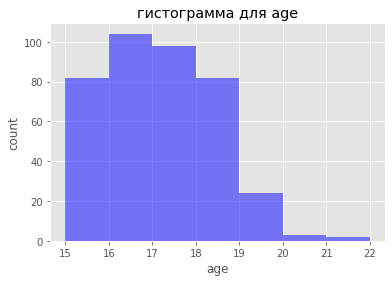

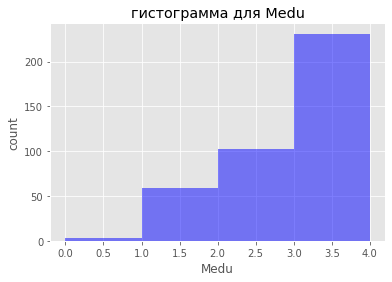

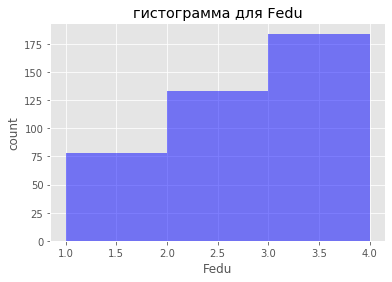

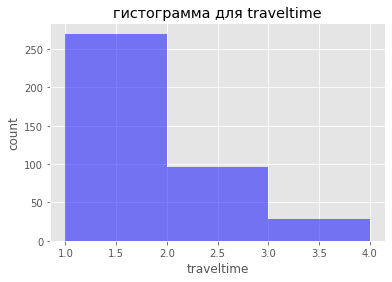

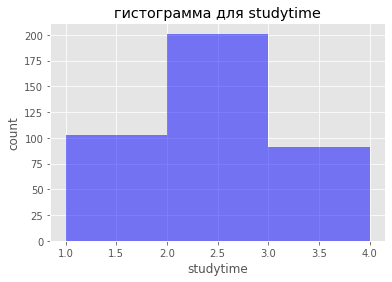

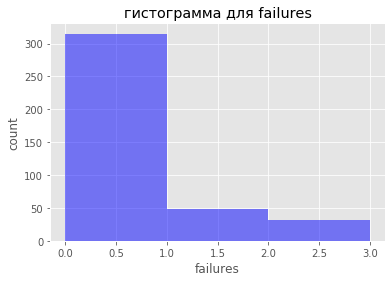

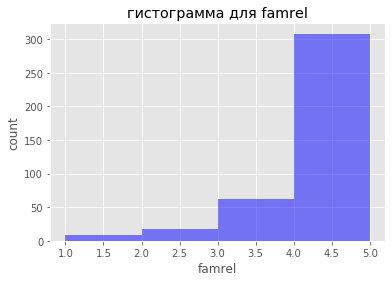

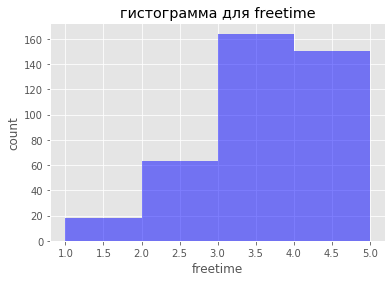

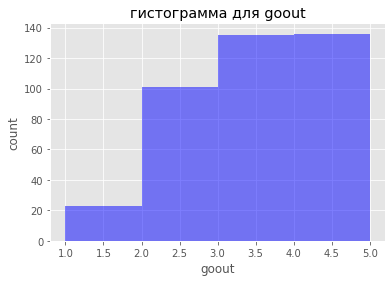

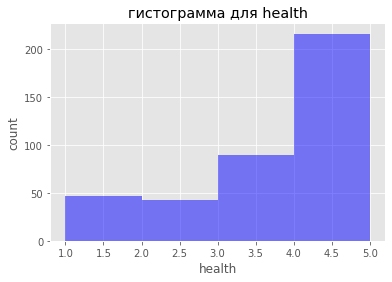

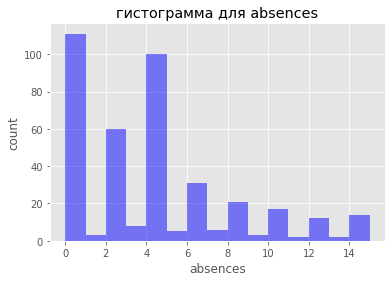

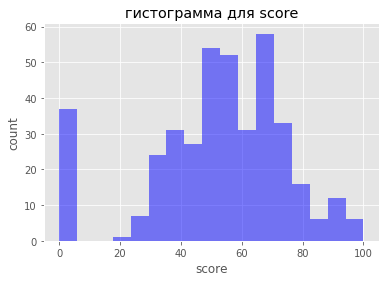

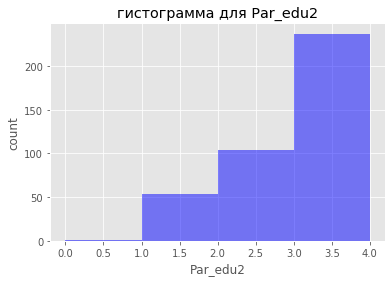

In [59]:
for col in find_cols_int(df_math):
    bins_constructor_int(col)

Есть выбросы в колонках 'Fedu', 'Famrel', 'absences', и новый признак 'Par_edu2'
целевая переменная 'score' так же не нормальная, ее оставим в покое

**Масштабы цыфр одинаковые, не вижу смысла стандартизировать**

In [ ]:
# рассмотрим прием с логарифмированием из-за длинного хвоста 
# df.loc[:,'Duration'] = df.Duration.apply(lambda w: np.log(w + 1))

В столбце famrel есть ошибка в знаке т.к. в столбце следующие значения 
 4.0    209
5.0     99
3.0     62
2.0     17
1.0      8
Name: famrel, dtype: int64
Минимальное значение теперь 1.0
25-й перцентиль: 2.0, 75-й перцентиль: 3.0, IQR: 1.0,  Столб Fedu Границы выбросов: [0.5, 4.5].


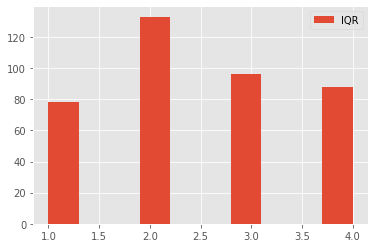

25-й перцентиль: 0.0, 75-й перцентиль: 6.0, IQR: 6.0,  Столб absences Границы выбросов: [-9.0, 15.0].


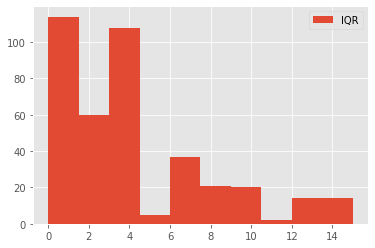

25-й перцентиль: 2.0, 75-й перцентиль: 4.0, IQR: 2.0,  Столб Par_edu2 Границы выбросов: [-1.0, 7.0].


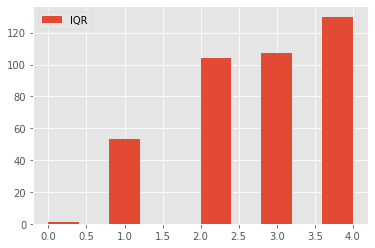

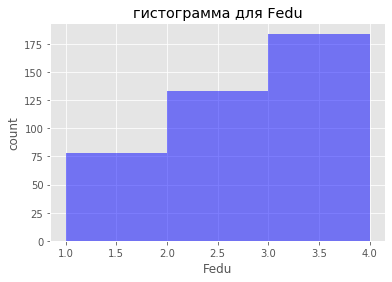

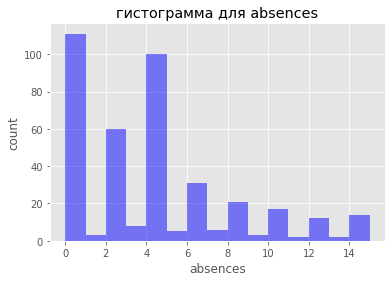

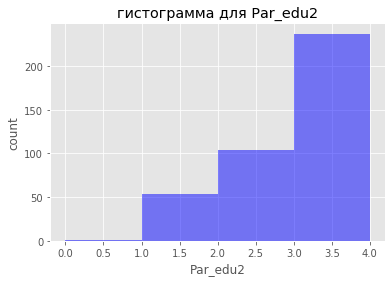

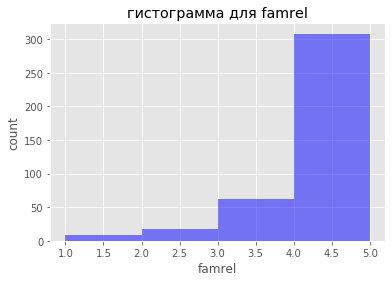

In [60]:
# Устраняем выбросы в famrel
print('В столбце famrel есть ошибка в знаке т.к. в столбце следующие значения \n',
      df_math.famrel.value_counts())  # Есть отрицательные значения 1шт, меняем ему знак
df_math.famrel = df_math.famrel.apply(lambda x: x if x > 0 else x*(-1))
print('Минимальное значение теперь', df_math.famrel.value_counts().index.min())

# Устраняем выбросы в Fedi, absences
cols_vibrosi = ['Fedu', 'absences', 'Par_edu2']
remove_vibrosi(cols_vibrosi)

# Проверяеям все ли норм после обработки
cols_vibrosi = ['Fedu', 'absences', 'Par_edu2', 'famrel']
for col in cols_vibrosi:
    bins_constructor_int(col)

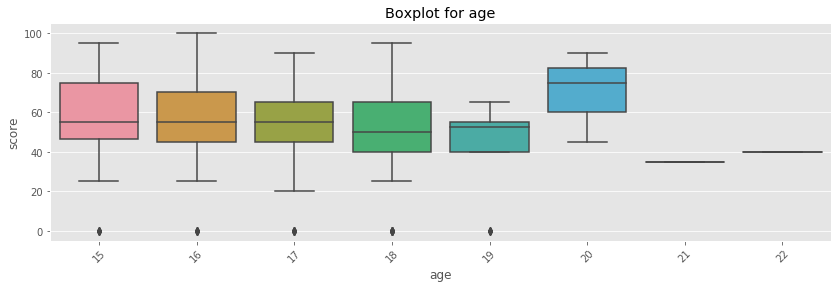

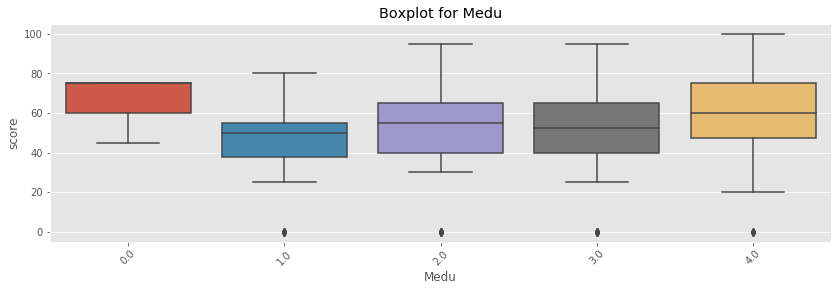

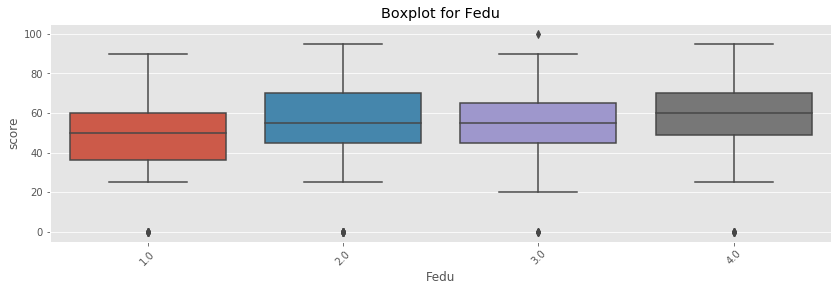

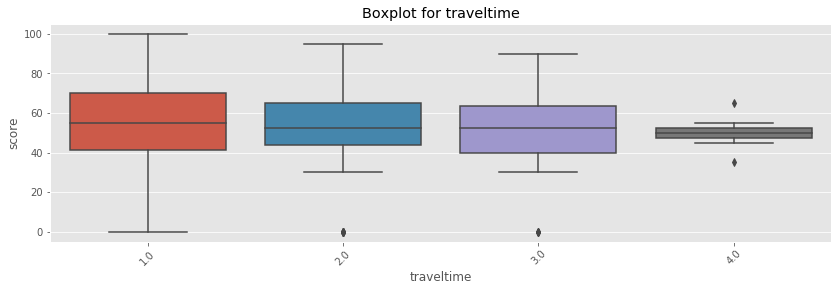

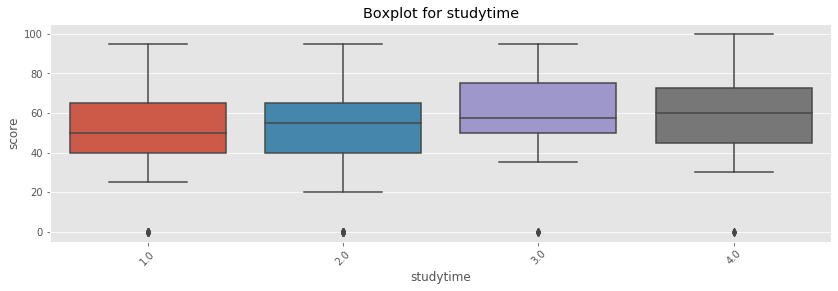

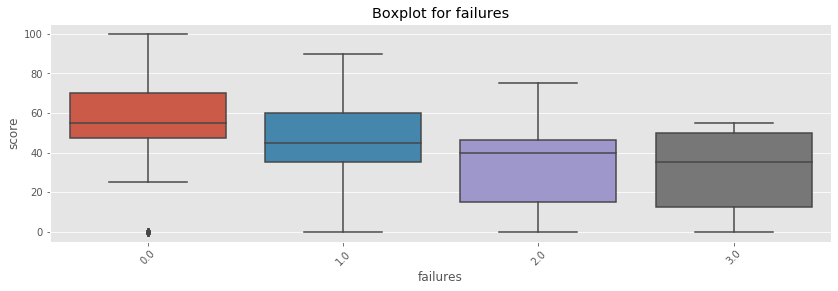

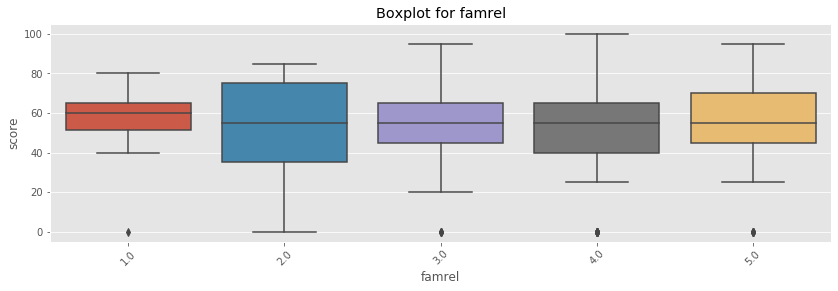

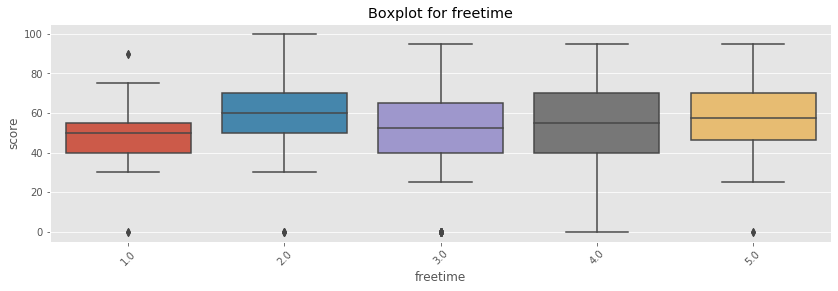

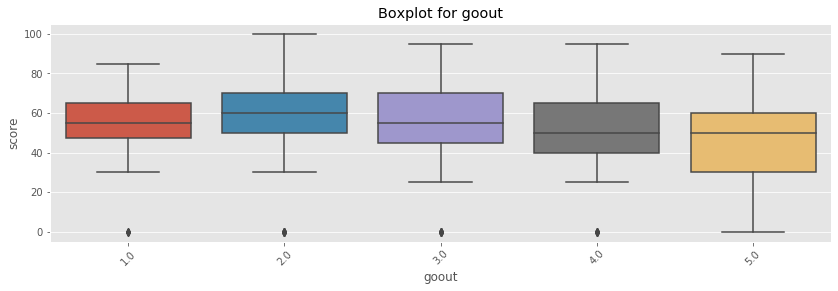

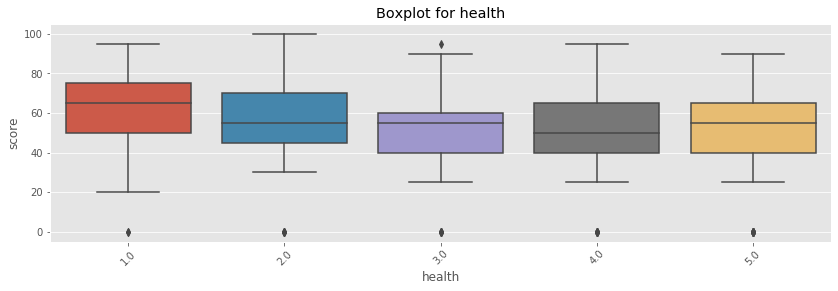

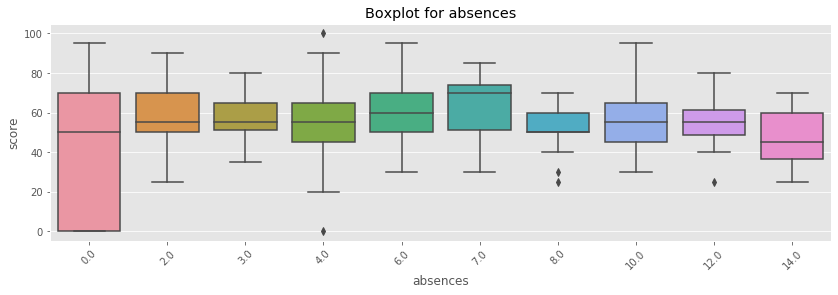

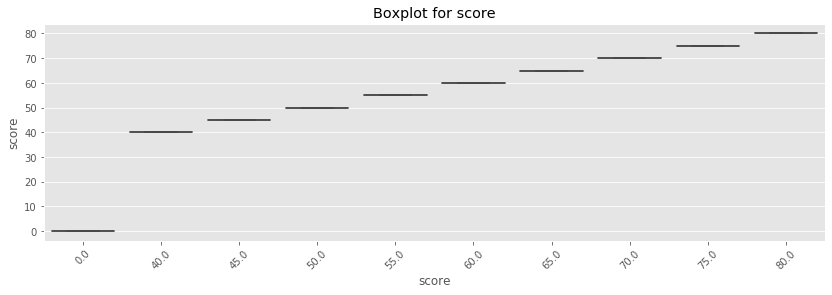

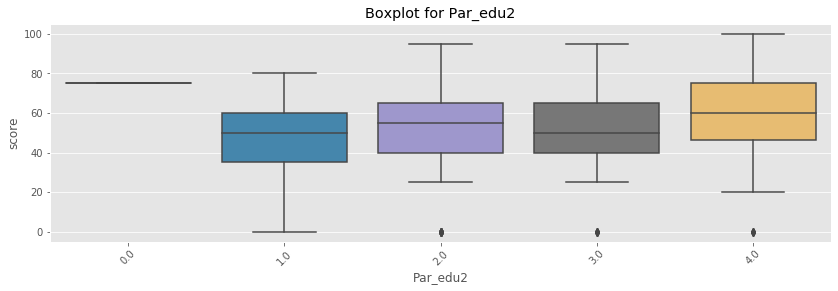

In [61]:
for col in find_cols_int(df_math):
    get_boxplot(col)

**Много выбросов когда score = 0, что с этим делать? дропнуть?**

In [63]:
# Поиск колонок со статически значимыми различиями по t-test
result_col_ttest = []
for col in df_math.columns:
    result_col_ttest.append(get_stat_dif(col))

result_col_ttest = [i for i in result_col_ttest if i]  # Убираем None
print('Статически влияют следующие колонки: {}'.format(result_col_ttest))

C:\Users\ivtar\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3367: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
C:\Users\ivtar\Anaconda3\lib\site-packages\numpy\core\_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\ivtar\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\ivtar\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Users\ivtar\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


Статически влияют следующие колонки: ['address', 'Medu', 'Mjob', 'failures', 'higher', 'romantic', 'absences', 'score', 'Par_edu2']


(13.0, 0.0)

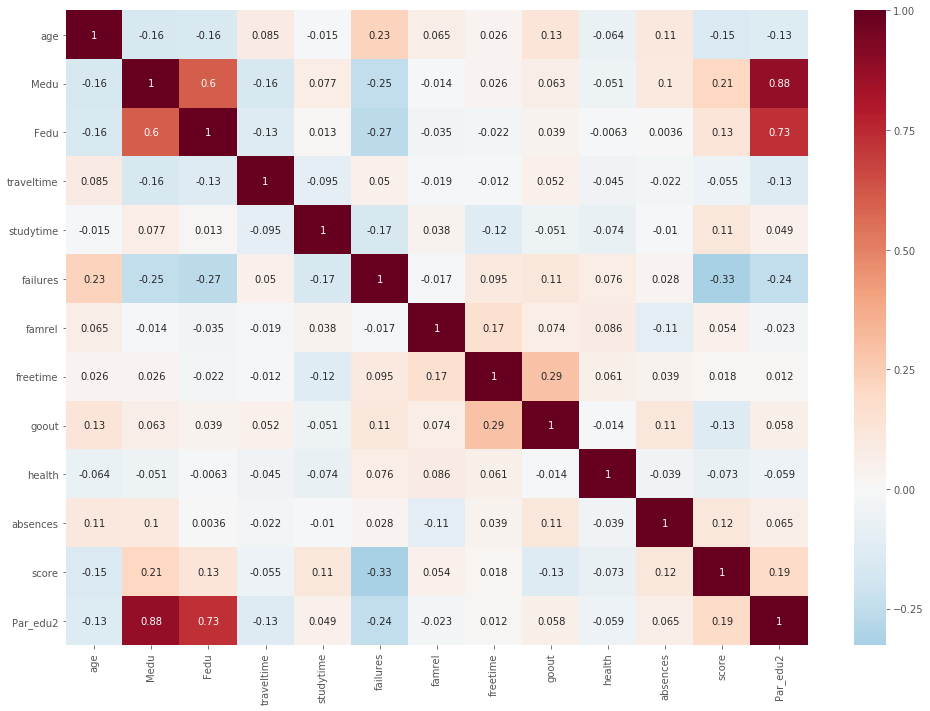

In [37]:
# Метод корреляции Пирсона, который определяет степень линейной зависимости в парах признаков
C = df_math.corr(method='pearson')
# # представим корреляционную матрицу в виде "тепловой карты" с помощью функции heatmap из библиотеки seaborn
# import seaborn as sns # библиотека для визуализации статистических данных
plt.figure(figsize=(14, 10))  # размер графика
ax = sns.heatmap(C, cmap=sns.color_palette(
    "RdBu_r", 1000),  center=0, annot=True)
i, k = ax.get_ylim()
plt.tight_layout()
ax.set_ylim(i+0.5, k-0.5)  # устанавливаем границы вручную

'studitime, granular' и 'studitime' - кооф 1 и -1, отбросим 'studitime, granular'

'Medu' и 'Fedu' корелирует с объединением 'Par_edu2', но не очень, новый столбец хлам 

In [38]:
df_math.drop('studytime, granular', axis=1, inplace=True)

KeyError: "['studytime, granular'] not found in axis"

In [39]:
# Проведем оценку что корелирует
C.score[abs(C.score) > 0.2].drop('score').sort_values()
# Запоминием столбцы
corelations_cols = list(
    C.score[abs(C.score) > 0.2].drop('score').sort_values().index)
print('Кореляция >0.2 у столбцов', corelations_cols)

Кореляция >0.2 у столбцов ['failures', 'Medu']


In [40]:
df_math

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,health,absences,score,Par_edu2
0,GP,F,18,U,GT3,A,4.0,4.0,at_home,teacher,course,mother,2.0,2.0,0.0,yes,no,no,no,yes,yes,yes,no,4.0,3.0,4.0,3.0,6.0,30.0,4.0
1,GP,F,17,U,GT3,T,1.0,1.0,at_home,other,course,father,1.0,2.0,0.0,no,yes,no,no,no,yes,yes,no,5.0,3.0,3.0,3.0,4.0,30.0,1.0
2,GP,F,15,U,LE3,T,1.0,1.0,at_home,other,other,mother,1.0,2.0,3.0,yes,no,yes,no,yes,yes,yes,yes,4.0,3.0,2.0,3.0,10.0,50.0,1.0
3,GP,F,15,U,GT3,T,4.0,2.0,health,other,home,mother,1.0,3.0,0.0,no,yes,yes,yes,yes,yes,yes,yes,3.0,2.0,2.0,5.0,2.0,75.0,4.0
4,GP,F,16,U,GT3,T,3.0,3.0,other,other,home,father,1.0,2.0,0.0,no,yes,yes,no,yes,yes,no,no,4.0,3.0,2.0,5.0,4.0,50.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390,MS,M,20,U,LE3,A,2.0,2.0,services,services,course,other,1.0,2.0,2.0,no,yes,yes,no,yes,yes,no,no,5.0,5.0,4.0,4.0,4.0,45.0,2.0
391,MS,M,17,U,LE3,T,3.0,1.0,services,services,course,mother,2.0,1.0,0.0,no,no,no,no,no,yes,yes,no,2.0,4.0,5.0,2.0,3.0,80.0,3.0
392,MS,M,21,R,GT3,T,1.0,1.0,other,other,course,other,1.0,1.0,3.0,no,no,no,no,no,no,no,no,5.0,5.0,3.0,3.0,3.0,35.0,1.0
393,MS,M,18,R,LE3,T,3.0,2.0,services,other,course,mother,3.0,1.0,0.0,no,no,no,no,no,yes,yes,no,4.0,4.0,1.0,5.0,0.0,50.0,3.0


In [41]:
# Долго и не понятно, удалить
# sns.pairplot(df_math, kind = 'reg')

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,health,absences,score,Par_edu2
school,,,,,,,,,,,,,
GP,16,3.0,2.0,1.0,2.0,0.0,4.0,3.0,3.0,4.0,4.0,55.0,3.0
MS,18,2.0,2.0,2.0,2.0,0.0,4.0,3.0,3.0,3.0,3.0,50.0,3.0


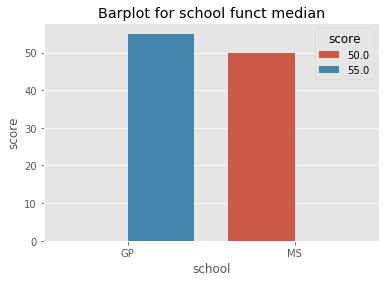

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,health,absences,score,Par_edu2
sex,,,,,,,,,,,,,
F,16.73,2.67,2.45,1.38,2.28,0.30,3.91,3.01,3.01,3.37,3.90,50.19,2.73
M,16.66,2.84,2.53,1.44,1.77,0.34,3.99,3.47,3.20,3.75,3.97,54.65,2.86


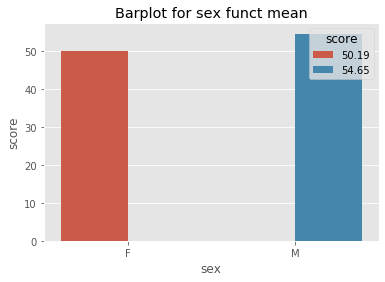

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,health,absences,score,Par_edu2
address,,,,,,,,,,,,,
R,17.04,2.43,2.35,1.75,2.11,0.43,3.96,3.11,2.95,3.66,4.23,46.93,2.53
U,16.61,2.84,2.53,1.32,2.02,0.29,3.94,3.26,3.14,3.52,3.86,53.73,2.86


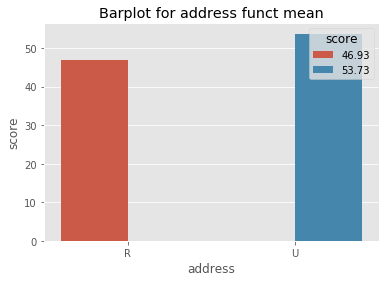

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,health,absences,score,Par_edu2
famsize,,,,,,,,,,,,,
GT3,16.68,2.78,2.53,1.39,2.08,0.32,3.96,3.22,3.08,3.59,3.67,51.42,2.84
LE3,16.74,2.66,2.37,1.45,1.93,0.33,3.92,3.25,3.17,3.45,4.63,54.67,2.66


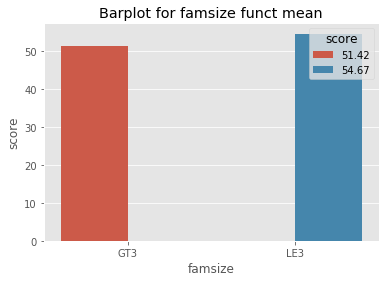

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,health,absences,score,Par_edu2
Pstatus,,,,,,,,,,,,,
A,16.64,3.19,2.78,1.22,2.03,0.31,3.92,3.08,2.97,3.53,4.94,55.14,3.17
T,16.70,2.71,2.46,1.43,2.04,0.32,3.95,3.24,3.12,3.55,3.84,52.02,2.75


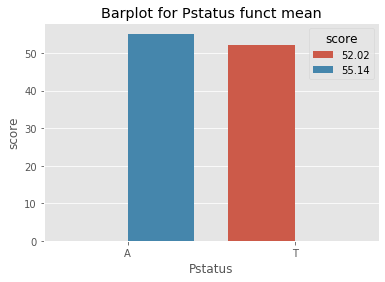

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,health,absences,score,Par_edu2
Mjob,,,,,,,,,,,,,
at_home,16.97,1.71,2.12,1.59,2.07,0.43,3.88,3.03,2.98,3.24,3.51,45.69,2.00
health,16.28,3.62,2.91,1.19,1.97,0.25,3.72,3.22,3.25,3.72,4.10,60.62,3.31
other,16.76,2.48,2.26,1.41,2.03,0.32,3.99,3.19,3.11,3.50,3.70,50.46,2.51
services,16.68,2.84,2.57,1.40,2.05,0.42,4.03,3.28,3.16,3.79,4.33,54.74,2.89
teacher,16.51,3.95,3.13,1.35,2.04,0.05,3.87,3.44,3.02,3.49,4.23,55.18,3.93


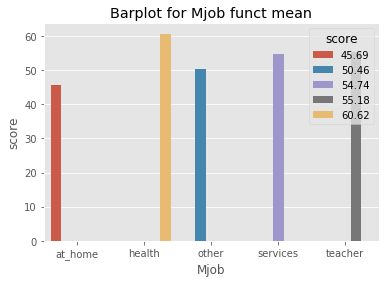

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,health,absences,score,Par_edu2
Fjob,,,,,,,,,,,,,
at_home,17.25,2.19,2.25,1.19,2.06,0.19,3.75,3.50,2.81,3.31,4.19,51.88,2.50
health,16.07,3.07,3.20,1.13,2.47,0.27,3.80,2.93,3.00,4.00,5.57,55.67,3.13
other,16.67,2.68,2.32,1.44,2.04,0.30,3.97,3.23,3.10,3.55,4.08,51.93,2.69
services,16.85,2.68,2.45,1.42,2.00,0.44,4.01,3.22,3.19,3.48,3.32,50.59,2.75
teacher,16.38,3.76,3.76,1.34,1.90,0.14,3.72,3.24,3.03,3.66,3.96,59.83,3.72


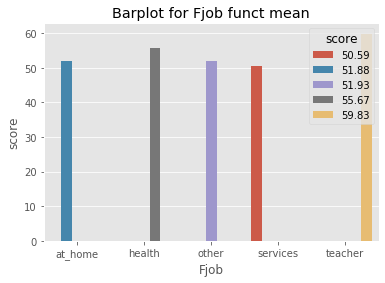

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,health,absences,score,Par_edu2
reason,,,,,,,,,,,,,
course,16.70,2.62,2.43,1.50,1.96,0.35,4.00,3.36,3.18,3.81,3.29,49.89,2.74
home,16.74,2.72,2.47,1.35,1.96,0.37,3.95,3.12,3.09,3.50,3.92,51.30,2.73
other,16.71,2.75,2.45,1.31,1.86,0.29,3.82,3.22,3.08,3.65,4.40,54.12,2.73
reputation,16.64,2.96,2.61,1.39,2.31,0.24,3.93,3.17,3.04,3.20,4.59,55.63,2.94


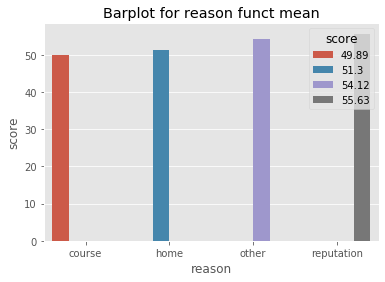

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,health,absences,score,Par_edu2
guardian,,,,,,,,,,,,,
father,16.43,2.67,2.64,1.47,2.02,0.26,3.91,3.21,2.93,3.71,3.60,53.43,2.64
mother,16.56,2.84,2.45,1.37,2.02,0.24,3.94,3.20,3.12,3.50,4.02,52.62,2.84
other,17.66,2.47,2.44,1.47,2.14,0.76,4.03,3.37,3.31,3.54,4.09,49.32,2.78


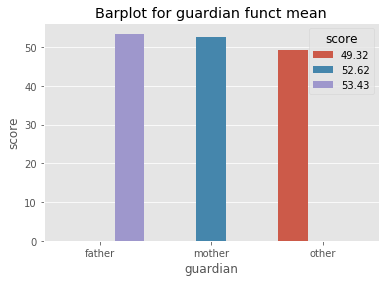

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,health,absences,score,Par_edu2
schoolsup,,,,,,,,,,,,,
no,16.83,2.76,2.48,1.41,2.03,0.32,3.95,3.25,3.12,3.57,3.83,52.97,2.80
yes,15.85,2.67,2.60,1.40,2.10,0.33,3.90,3.06,3.02,3.38,4.57,47.88,2.71


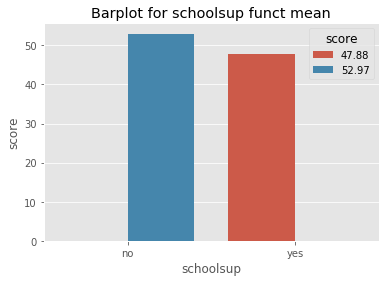

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,health,absences,score,Par_edu2
famsup,,,,,,,,,,,,,
no,17.03,2.50,2.25,1.44,1.94,0.36,3.96,3.21,3.22,3.48,3.97,52.34,2.57
yes,16.49,2.91,2.64,1.39,2.10,0.29,3.94,3.23,3.03,3.59,3.91,52.28,2.93


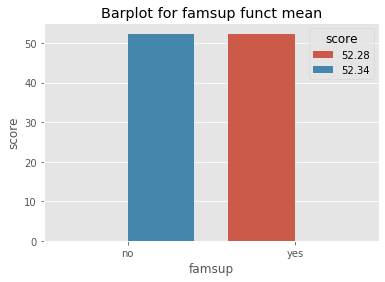

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,health,absences,score,Par_edu2
paid,,,,,,,,,,,,,
no,16.80,2.59,2.42,1.43,1.91,0.40,3.95,3.28,3.07,3.57,4.04,50.61,2.67
yes,16.56,2.96,2.59,1.38,2.20,0.21,3.95,3.16,3.15,3.52,3.80,54.51,2.94


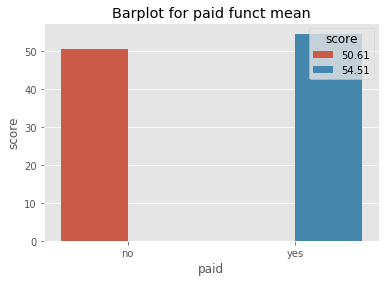

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,health,absences,score,Par_edu2
activities,,,,,,,,,,,,,
no,16.85,2.63,2.36,1.41,1.94,0.39,3.87,3.15,3.05,3.52,3.82,51.79,2.63
yes,16.54,2.87,2.61,1.40,2.13,0.25,4.02,3.30,3.16,3.58,4.04,52.80,2.94


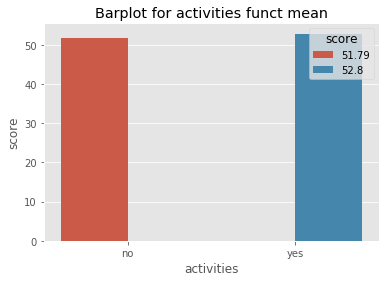

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,health,absences,score,Par_edu2
nursery,,,,,,,,,,,,,
no,16.99,2.32,2.16,1.48,1.90,0.44,3.99,3.29,3.11,3.60,3.35,49.88,2.43
yes,16.62,2.87,2.58,1.39,2.07,0.29,3.94,3.21,3.10,3.54,4.09,52.94,2.88


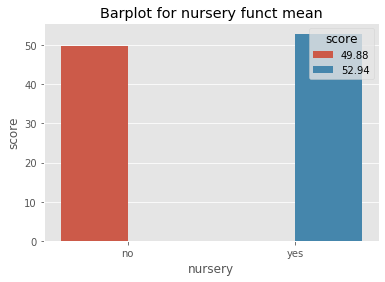

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,health,absences,score,Par_edu2
higher,,,,,,,,,,,,,
no,18.00,1.9,1.65,1.6,1.40,1.25,3.95,3.50,3.2,3.50,2.00,33.75,2.05
yes,16.63,2.8,2.54,1.4,2.07,0.27,3.95,3.21,3.1,3.55,4.03,53.29,2.83


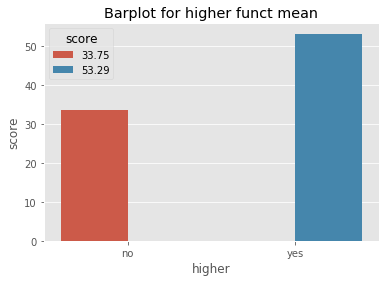

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,health,absences,score,Par_edu2
internet,,,,,,,,,,,,,
no,17.11,2.23,2.11,1.48,1.97,0.44,3.82,2.98,2.82,3.82,3.39,47.30,2.31
yes,16.62,2.85,2.56,1.40,2.05,0.30,3.97,3.27,3.16,3.50,4.03,53.22,2.88


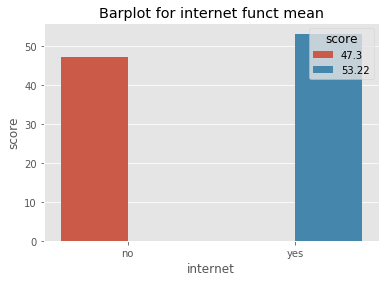

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,health,absences,score,Par_edu2
romantic,,,,,,,,,,,,,
no,16.62,2.72,2.48,1.40,2.02,0.27,3.99,3.27,3.11,3.52,3.77,54.21,2.76
yes,16.84,2.81,2.52,1.42,2.07,0.41,3.87,3.15,3.09,3.60,4.24,48.63,2.85


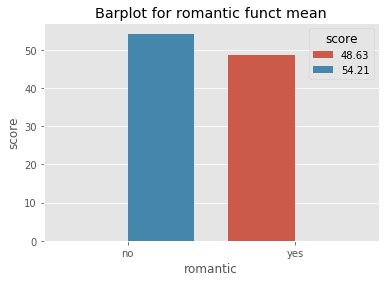

In [42]:
categorical_cols = Diff(list(df_math.columns), find_cols_int(df_math))

for column in categorical_cols:
    if column in {'school'}:
        look_at_categ_param(column, 'median')
    else:
        look_at_categ_param(column)

Что мы увидели - на score влияют, под влияют значит значение score отличается на 5 или более:
**'school', 'sex', 'address', 'Mjob', 'Fjob', 'reason', 'schoolsup', 'higher', 'internet'(с натяжкой), 'romantic'**

In [43]:
cols_nomenativ_vliyanie = ['school', 'sex', 'address', 'Mjob',
                           'Fjob', 'reason', 'schoolsup', 'higher', 'internet', 'romantic']

# Этап №3 Описание данных
какие признаки выберем для модели? а вот какие

In [82]:
# Для оценкия я оставил следующее число признаков:
result_cols = list(
    set(result_col_ttest + cols_nomenativ_vliyanie + corelations_cols))
len(result_cols)


15

In [90]:
df_math_clean = df_math[result_cols]

In [93]:
df_math_clean.head()

,schoolsup,Fjob,score,sex,internet,school,higher,Par_edu2,reason,Medu,romantic,Mjob,absences,address,failures
0,yes,teacher,30.0,F,yes,GP,yes,4.0,course,4.0,no,at_home,6.0,U,0.0
1,no,other,30.0,F,yes,GP,yes,1.0,course,1.0,no,at_home,4.0,U,0.0
2,yes,other,50.0,F,yes,GP,yes,1.0,other,1.0,yes,at_home,10.0,U,3.0
3,no,other,75.0,F,yes,GP,yes,4.0,home,4.0,yes,health,2.0,U,0.0
4,no,other,50.0,F,no,GP,yes,3.0,home,3.0,no,other,4.0,U,0.0


In [98]:
# Сделать one-hot encoding для некоторых признаков
# тут берем все столбцы, вычитаем из них те что int и float
one_hot_cols = Diff(list(df_math_clean.columns), find_cols_int(df_math_clean))

# # делаем dummies
df_math_clean = pd.get_dummies(df_math_clean, columns=one_hot_cols)

In [99]:
# Форма нового датасета стада 395 на 33, была 395 на 30. Во всех полях цифры
df_math_clean.shape


(395, 33)

In [101]:
# Смотрим пропуски в новом датасете
df_math_clean.info()
df_math_clean.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 33 columns):
score                395 non-null float64
Par_edu2             395 non-null float64
Medu                 395 non-null float64
absences             395 non-null float64
failures             395 non-null float64
schoolsup_no         395 non-null uint8
schoolsup_yes        395 non-null uint8
Fjob_at_home         395 non-null uint8
Fjob_health          395 non-null uint8
Fjob_other           395 non-null uint8
Fjob_services        395 non-null uint8
Fjob_teacher         395 non-null uint8
sex_F                395 non-null uint8
sex_M                395 non-null uint8
internet_no          395 non-null uint8
internet_yes         395 non-null uint8
school_GP            395 non-null uint8
school_MS            395 non-null uint8
higher_no            395 non-null uint8
higher_yes           395 non-null uint8
reason_course        395 non-null uint8
reason_home          395 non-null uint8
reaso

score                0
Par_edu2             0
Medu                 0
absences             0
failures             0
schoolsup_no         0
schoolsup_yes        0
Fjob_at_home         0
Fjob_health          0
Fjob_other           0
Fjob_services        0
Fjob_teacher         0
sex_F                0
sex_M                0
internet_no          0
internet_yes         0
school_GP            0
school_MS            0
higher_no            0
higher_yes           0
reason_course        0
reason_home          0
reason_other         0
reason_reputation    0
romantic_no          0
romantic_yes         0
Mjob_at_home         0
Mjob_health          0
Mjob_other           0
Mjob_services        0
Mjob_teacher         0
address_R            0
address_U            0
dtype: int64

In [160]:
dfx = df_math_clean.drop('score', axis=1).to_numpy()
dfy = df_math_clean[['score']].to_numpy()

# Разделите выборку на обучающую и тренировочную с параметрами test_size=0.3, random_state=42
X_train, X_test, Y_train, Y_test = train_test_split(
    dfx, dfy, test_size=0.3, random_state=42)


# Обозначаем, что наша модель - линейная регрессия
linreg_model = LinearRegression()
linreg_model.fit(X_train, Y_train)  # обучаем модель на обучающих данных


y_pred = linreg_model.predict(X_test)
y_pred


print_metrics(Y_test, y_pred)

MAE: 17.0598
RMSE: 21.9331


In [169]:
linreg_model.coef_.reshape(1,-1) # коэффициенты модели


array([[-0.92625285,  1.11619339,  0.80531989, -8.59847043,  2.32105369,
        -2.32105369, -1.41319545, -2.81262266, -0.52519466,  0.30073982,
         4.45027294, -1.23533112,  1.23533112, -1.6501028 ,  1.6501028 ,
        -1.44471657,  1.44471657, -6.1465787 ,  6.1465787 , -2.23586244,
        -2.8748193 ,  3.42173823,  1.68894351,  1.91703928, -1.91703928,
        -2.49168125,  6.92187312, -0.98935128,  0.04138113, -3.48222171,
        -1.26354312,  1.26354312]])

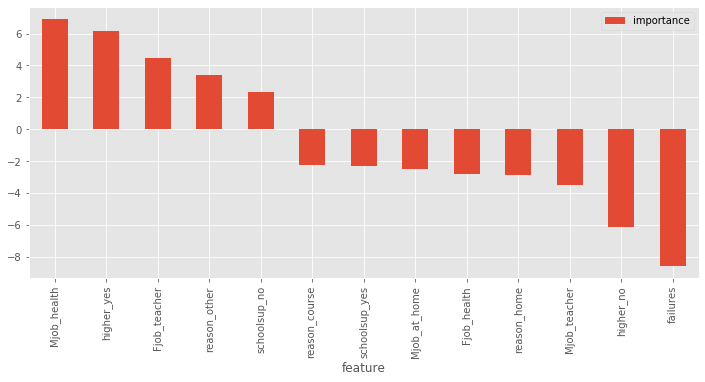

In [183]:
# Посмотрим на то, какие признаки вносят в продажи наибольший вклад в прогноз.


feature_names = df_math_clean.drop('score', axis=1).columns

featureImportance = pd.DataFrame({"feature": feature_names.to_numpy(),  "importance": linreg_model.coef_.ravel()})

featureImportance.set_index('feature', inplace=True)
featureImportance.sort_values(['importance'], ascending=False, inplace=True)
# featureImportance.head(10)
featureImportance[abs(featureImportance['importance'])>2].plot(kind='bar', figsize=(12,5));
# featureImportance[abs(featureImportance['importance'])>2]

# Выводы
После обучения регрессии на 33 - 1 (score) признаках получили следующие метрики

MAE: 17.0598

RMSE: 21.9331

Коофициенты, которые создала модель мы можем охарактеризовать так:

коофициенты берем abs(x)>2

**Сильно влияют со знаком +:**

* Mjob_health (мама врач)
* higher_yes (хочет поступить)
* Fjob_teacher (отец учитиль)
* reason_other (другие причины поступить)
* schoolsup_no (нет семейной образовательной поддержки)

**Сильно влияют со знаком -:**
* reason_course	(причина выбора образовательная система)
* schoolsup_yes	(есть семейная образовательная поддержка)
* Mjob_at_home	(мама не работате)
* Fjob_health	(папа врач)
* reason_home	(причина выбора близость к дому)
* Mjob_teacher	(мама учитель)
* higher_no	    (не хочет поступать)
* failures	    (число прогулов)
